# Analysis of Vivino user preferences

## Factors affecting the price

In this mission our goal is to understand which factors (of those available to our analysis) contribute to the price of the wine. 
The following questions can be analyzed in more detail: 
* how different features influence the price of a bottle of wine
* analyze the connection between ratings and price (whether variance in scores increases for more expensive wines) 
* see whether temperature in particular regions can affect the price 
* see whether it's possible to get a score adjusted to price (i.e. eliminate bias in user expectatoins in view of the price)
* estimate the predictive power for the rating with price and without price

In [1]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd
from settings import * 

db_connection_str = f'mysql+pymysql://admin:{db_pass}@{db_url}:3306/vivino'
db_connection = create_engine(db_connection_str)

In [362]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will work with a dataframe containing all features that might be important for our analysis. In order to do that we need to join several tables from our SQL database.

Below is the header of a vintage table (which however does not contain any qualitative data about the wine).

In [4]:
query = (
"""
SELECT * FROM vintage
LIMIT 500
"""
)

df = pd.read_sql(query, con=db_connection)
df.head()

,id,seo_name,name,wine_id,year,has_valid_ratings,status,ratings_count,ratings_average,labels_count,price_id,price
0,1832,penfolds-bin-707-cabernet-sauvignon-2005,Penfolds Bin 707 Cabernet Sauvignon 2005,1264,2005,1,Normal,169,4.5,1543,19903206,299.500
1,2036,mazzei-siepi-2005,Mazzei Siepi 2005,1471,2005,1,Normal,537,4.4,2114,22309019,46.390
2,2201,antinori-tuscany-tenuta-tignanello-solaia-2005,Antinori Tenuta Tignanello 'Solaia' 2005,1651,2005,1,Normal,804,4.6,5265,23073375,432.500
3,2202,antinori-tuscany-tignanello-2005,Antinori Tignanello 2005,1652,2005,1,Normal,1745,4.5,9107,17920617,102.840
4,2225,antinori-tuscany-pian-delle-vigne-brunello-di-...,Antinori Pian delle Vigne Brunello di Montalci...,1675,2003,1,Normal,213,4.3,1043,21514027,116.667


Below is the query that extracts all potentially relevant information from the database: 
about the vintage itself (eg. year, price, ratings), type (red/white/etc), wine qualities (flavour, intensity, acidity, etc), country, region, winery, style, bottle type (to select only those with classic bottle size), number of grape varieties used, appearance in toplists and average rank.

In [353]:
query = (
"""
SELECT v.id, v.year, v.ratings_count, v.ratings_average, v.price, 
w.acidity, w.fizziness, w.intensity, w.sweetness, w.tannin, w.vintage_type, w.is_natural, w.seo_name AS wine_name, w.id AS wine_id,
r.name AS region, 
c.name AS country,
s.name AS style_name, s.body, s.acidity AS style_acidity,
t.name AS type_name,
w2.name AS winery_name,
p.bottle_type,
COUNT(vt.toplist_id) AS toplist_count, AVG(vt.rank) AS average_rank,
COUNT(sg.grape_id) AS grape_count
FROM vintage AS v
LEFT JOIN wine AS w ON w.id = v.wine_id
LEFT JOIN region AS r ON w.region_id = r.id
LEFT JOIN country AS c on r.country_code = c.code
LEFT JOIN style AS s ON w.style_id = s.id
LEFT JOIN type AS t ON t.id = w.type_id
LEFT JOIN style_grape AS sg ON sg.style_id = s.id
LEFT JOIN winery AS w2 ON w2.id = w.winery_id
LEFT JOIN price AS p ON v.price_id = p.id
LEFT JOIN vintage_toplist AS vt ON vt.vintage_id = v.id
GROUP BY v.id
"""
)

df = pd.read_sql(query, con=db_connection)
df.head()

,id,year,ratings_count,ratings_average,price,acidity,fizziness,intensity,sweetness,tannin,...,country,style_name,body,style_acidity,type_name,winery_name,bottle_type,toplist_count,average_rank,grape_count
0,1832,2005,169,4.5,299.500,3.39891,NaN,3.98319,1.71259,3.52832,...,Australia,Australian Cabernet Sauvignon,4.0,3.0,Red,Penfolds,Bottle (0.75l),0,NaN,1
1,2036,2005,537,4.4,46.390,3.10746,NaN,3.43923,1.82238,2.92387,...,Italy,Tuscan Red,3.0,2.0,Red,Mazzei,Bottle (0.75l),0,NaN,4
2,2201,2005,804,4.6,432.500,3.07319,NaN,3.40041,1.89079,2.95559,...,Italy,Tuscan Red,3.0,2.0,Red,Antinori,Bottle (0.75l),0,NaN,4
3,2202,2005,1745,4.5,102.840,3.07621,NaN,3.38235,1.71550,2.96347,...,Italy,Tuscan Red,3.0,2.0,Red,Antinori,Bottle (0.75l),0,NaN,4
4,2225,2003,213,4.3,116.667,3.80301,NaN,3.19779,1.59608,3.42035,...,Italy,Italian Brunello,5.0,3.0,Red,Antinori,Bottle (0.75l),0,NaN,1


## Overview of each variable

First, we review each column and its statistics (that differs between numerical and categorical variables).

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55819 entries, 0 to 55818
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               55819 non-null  int64  
 1   year             55819 non-null  int64  
 2   ratings_count    55819 non-null  int64  
 3   ratings_average  55819 non-null  float64
 4   price            55819 non-null  float64
 5   acidity          48202 non-null  float64
 6   fizziness        1508 non-null   float64
 7   intensity        48202 non-null  float64
 8   sweetness        46694 non-null  float64
 9   tannin           33554 non-null  float64
 10  vintage_type     55819 non-null  int64  
 11  is_natural       55819 non-null  int64  
 12  wine_name        55819 non-null  object 
 13  wine_id          55819 non-null  int64  
 14  region           55773 non-null  object 
 15  country          55773 non-null  object 
 16  style_name       49766 non-null  object 
 17  body        

In [359]:
df.iloc[:,1:12].describe(include='all')

,year,ratings_count,ratings_average,price,acidity,fizziness,intensity,sweetness,tannin,vintage_type,is_natural
count,55819.000000,55819.000000,55819.000000,55819.000000,48202.000000,1508.000000,48202.000000,46694.000000,33554.000000,55819.000000,55819.000000
mean,1988.488794,302.603845,3.993465,92.111515,3.591589,4.121940,3.658274,1.759363,3.271468,0.013687,0.044537
std,219.818566,1063.017821,0.320202,615.417848,0.634221,0.617640,0.731353,0.494513,0.654076,0.119083,0.206286
min,0.000000,25.000000,2.300000,1.470000,1.105340,1.000000,1.000000,1.000000,1.054910,0.000000,0.000000
25%,2012.000000,49.000000,3.800000,14.990000,3.135020,3.905885,3.097400,1.502660,2.854580,0.000000,0.000000
50%,2015.000000,102.000000,4.000000,26.340000,3.572490,4.334035,3.810690,1.657575,3.334230,0.000000,0.000000
75%,2017.000000,252.000000,4.200000,55.000000,4.076560,4.428698,4.185860,1.877500,3.697835,0.000000,0.000000
max,2020.000000,90936.000000,5.000000,42100.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,1.000000


In [360]:
df.iloc[:,12:].describe(include='all')

,wine_name,wine_id,region,country,style_name,body,style_acidity,type_name,winery_name,bottle_type,toplist_count,average_rank,grape_count
count,55819,5.581900e+04,55773,55773,49766,49766.000000,49766.000000,55819,55803,55819,55819.000000,1457.000000,55819.000000
unique,21100,NaN,1656,47,283,NaN,NaN,7,10026,3,NaN,NaN,NaN
top,pomerol,NaN,Saint-Émilion Grand Cru,France,Burgundy Côte de Nuits Red,NaN,NaN,Red,M. Chapoutier,Bottle (0.75l),NaN,NaN,NaN
freq,750,NaN,1259,23031,2166,NaN,NaN,36593,248,53808,NaN,NaN,NaN
mean,NaN,1.614050e+06,NaN,NaN,NaN,3.745971,2.816401,NaN,NaN,NaN,0.096168,6.137497,2.426593
std,NaN,1.582791e+06,NaN,NaN,NaN,0.857454,0.434923,NaN,NaN,NaN,0.815001,3.984397,2.020728
min,NaN,2.960000e+02,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
25%,NaN,7.687330e+05,NaN,NaN,NaN,3.000000,3.000000,NaN,NaN,NaN,0.000000,3.000000,1.000000
50%,NaN,1.219018e+06,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,0.000000,6.000000,1.000000
75%,NaN,1.901594e+06,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,0.000000,9.000000,4.000000


The following columns have null values: 
* acidity, intensity, sweetness, tannin (if necessary, can be resolved by imputation from similar style) 
* fizziness (can be either resolved by imputation from similar style, or dropped completely) 
* region, country (can be dropped) 
* winery name (can be dropped) 
* average rank (can impute certain value exceeding the highest value among non-nulls, for example, 30)
* style, body (can be dropped) 
* style_acidity (can be dropped since it repeats the acidity columns)

Some information about the useful columns: 
* `year`: from 0 (meaning N.V.) to 2020, median 2015
* `ratings_count`: around 300 in average per vintage
* `ratings_average`: from 2.3 to 5 with mean around 3.99
* `price`: from 1.5 GBP to 42.1 th GBP, median price arounf 26 GBP
* `acidity` (as opposed to softness), `fizziness`, `intensity`, `sweetness` (as opposed to dryness), `tannin`: range from 1 to 5
* `vintage_type`: 0, 1 or 2, exact nature yet unclear
* `is_natural`: 0 or 1
* `wine_name`: around 21.1 th unique records
* `region`: 1656 unique records
* `country`: 47 unique records
* `style_name`: 283 unique records
* `body` (as opposed to lightness) and `style_acidity`: range from 1 to 5
* `type_name`: Red, White, Sparkling, Rose, Dessert, Fortified, Other
* `winery_name`: more than 10 ths unique wineries
* `bottle_type`: normal bottle (0.75l) for most of the wines, half bottle (0.375l) or magnum bottle (1.5l)
* `toplist_count`: how many times certain vintage appears in any toplists (up to 30)
* `average_rank`: for those vintages that appear in toplists, this represents the average rank, ranging from 1 to 20
* `grape_count`: the number of distinct types of grapes used to prepare wine, ranging from 1 to 30

In [361]:
df.columns

Index(['id', 'year', 'ratings_count', 'ratings_average', 'price', 'acidity',
       'fizziness', 'intensity', 'sweetness', 'tannin', 'vintage_type',
       'is_natural', 'wine_name', 'wine_id', 'region', 'country', 'style_name',
       'body', 'style_acidity', 'type_name', 'winery_name', 'bottle_type',
       'toplist_count', 'average_rank', 'grape_count'],
      dtype='object')

Now we'll visualize some of the frequency distributions of the variables in our table

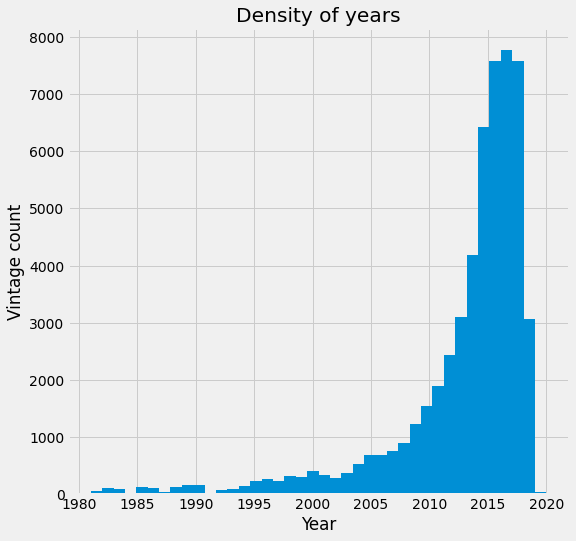

In [526]:
plt.figure(figsize=(8, 8))
df[df.year > 1980].year.hist(bins=40)
plt.xlabel('Year')
plt.ylabel('Vintage count')
plt.title('Density of years')
plt.show()

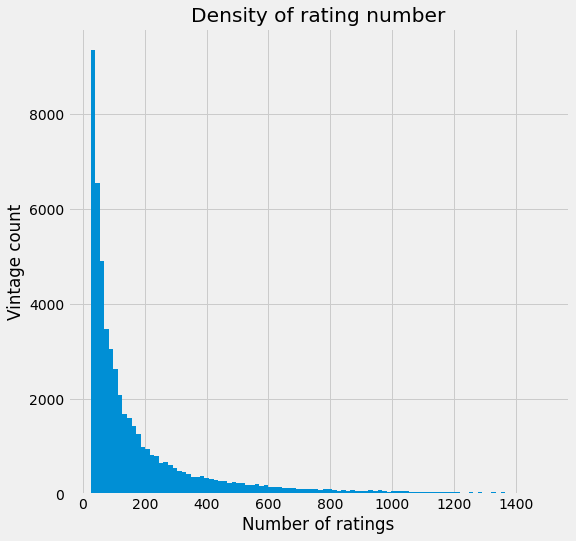

In [527]:
plt.figure(figsize=(8, 8))
df[df.ratings_count < 1500].ratings_count.hist(bins=100)
plt.xlabel('Number of ratings')
plt.ylabel('Vintage count')
plt.title('Density of rating number')
plt.show()

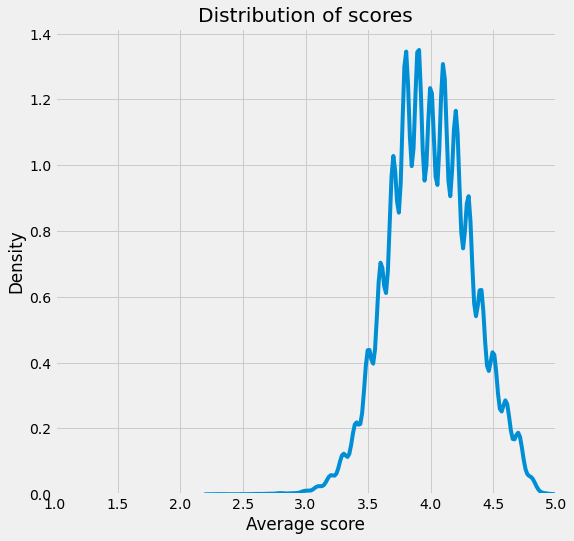

In [530]:
plt.figure(figsize=(8, 8))
sns.kdeplot(df.ratings_average)
plt.xlim(1,5)
plt.xlabel('Average score')
plt.ylabel('Density')
plt.title('Distribution of scores')
plt.show()

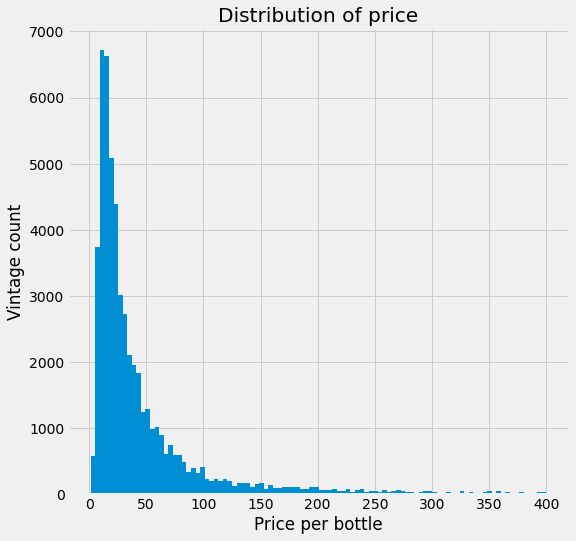

In [531]:
plt.figure(figsize=(8, 8))
df[df.price < 400].price.hist(bins=100)
plt.xlabel('Price per bottle')
plt.ylabel('Vintage count')
plt.title('Distribution of price')
plt.show()

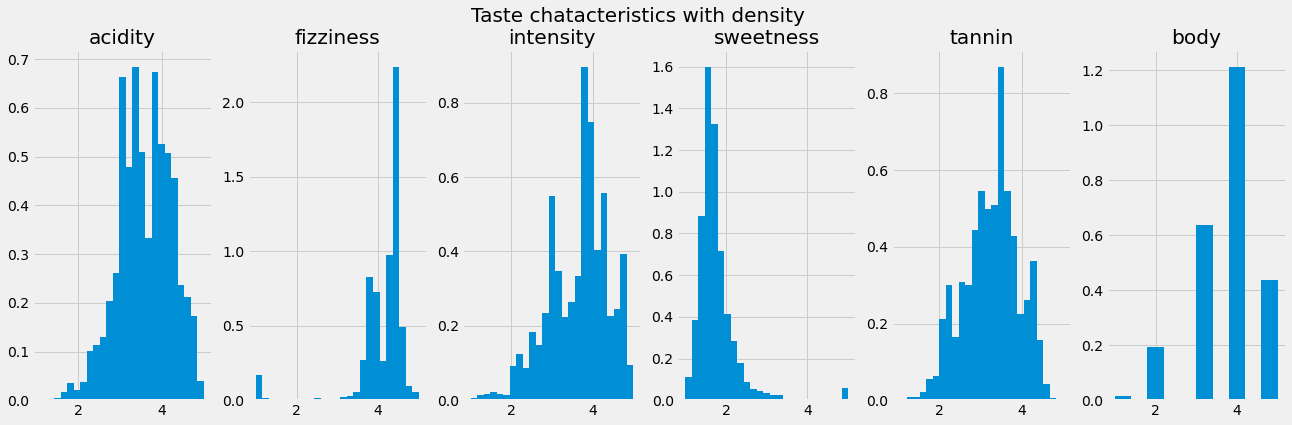

In [532]:
fig, axes = plt.subplots(1, 6, figsize=(20, 6))
plt.suptitle('Taste chatacteristics with density', size=20)
axes[0].hist(df['acidity'], density=True, bins=25)
axes[0].set_title('acidity')
axes[1].hist(df['fizziness'], density=True, bins=25)
axes[1].set_title('fizziness')
axes[2].hist(df['intensity'], density=True, bins=25)
axes[2].set_title('intensity')
axes[3].hist(df['sweetness'], density=True, bins=25)
axes[3].set_title('sweetness')
axes[4].hist(df['tannin'], density=True, bins=25)
axes[4].set_title('tannin')
axes[5].hist(df['body'], density=True, bins=10)
axes[5].set_title('body')
plt.show()

In [356]:
df['vintage_type'].value_counts()

0    55074
1      726
2       19
Name: vintage_type, dtype: int64

In order to better understand the nature of the variable 'vintage types' we review separately each of them, and analyze composition of years. 
* **Vintage type 0**: all vintages that have an indication of year (from 1818 to 2020)
* **Vintage type 1**: most of the vintages marked as N.V. (and some individual items marked as non N.V. - to be investigated further)
* **Vintage type 2**: only a few items, some of them matked N.V., others matked with a year. To be investigated further. 

In [447]:
df[df['vintage_type'] == 0]['year'].value_counts().sort_index()

1818       1
1900       1
1910       1
1912       1
1920       1
        ... 
2016    7575
2017    7768
2018    7572
2019    3058
2020      34
Name: year, Length: 91, dtype: int64

In [449]:
df[df['vintage_type'] == 1]['year'].value_counts().head()

0       665
2012      6
2004      5
2009      5
2008      5
Name: year, dtype: int64

In [450]:
df[df['vintage_type'] == 2]['year'].value_counts().head()

0       8
2015    1
2014    1
2013    1
2012    1
Name: year, dtype: int64

In order to investigate why some of the wines have vintage type = 1 and at the same time year 'non-N.V.', we can check individual web pages to find the clues. 

The web-page of each vintage has the format: `https://www.vivino.com/GB/en/[wine_name]/w/[wine_id]?year=[year]`

From a quick review of several examples, we can see that for these types of wines most have no indication of a year on the bottle label, so we assume that year might have been attributed incorrectly. In the future analysis we might want to exclude such inconsistent records.

In [451]:
df[(df['vintage_type'] == 1) & (df['year'] != 0)][['wine_name', 'wine_id', 'year', 'vintage_type']].head()

,wine_name,wine_id,year,vintage_type
62,blanc-de-blancs-brut-champagne-grand-cru-le-me...,9240,1999,1
1026,blanc-de-blancs-brut-champagne-grand-cru-le-me...,9240,2008,1
1076,brut-carte-jaune-champagne,1128385,2008,1
1172,brut-champagne,8302,2008,1
1829,mv,1167182,2000,1


We have also made a manual check of several wines of type 2 that appear to have both N.V. and yearly vintages. Since both types usually are present, we can assume that type 2 refers to the mixed type of vintage (meaning, wine can either be made from the harvest of specific year, or from several years). No action needed.

In [452]:
df[df['vintage_type'] == 2][['wine_name', 'wine_id', 'year', 'vintage_type']].head()

,wine_name,wine_id,year,vintage_type
1269,rose-brut-champagne,1142212,2008,2
4722,edizione-cinque-autoctoni,21646,0,2
4723,malamado-malbec,19488,0,2
4801,rose-brut-champagne,1142212,0,2
6853,rose-brut-champagne,1142212,2009,2


In [490]:
country_freq = df['country'].value_counts(normalize=True)
country_freq.head(11)

France           0.412942
Italy            0.173202
Spain            0.092374
Portugal         0.069711
South Africa     0.047335
United States    0.045398
Australia        0.044753
Argentina        0.021157
New Zealand      0.020601
Chile            0.019974
Germany          0.016406
Name: country, dtype: float64

In [491]:
# remove countries with frequency less than 1% 
country_freq['Other'] = 0
for country in country_freq.keys(): 
    if country_freq[country] < 0.01:
        country_freq['Other'] += country_freq[country]
        country_freq = country_freq.drop(labels = country)

We can see that 11 countries cover the production of more than 95% of wines that can be imported to GB at a given price. Each of this countries accounts for at least 1% of the wine market. 

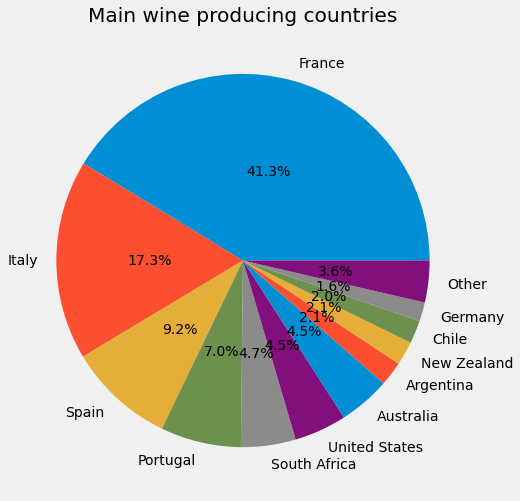

In [513]:
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 8))
plt.pie(country_freq, normalize=True, autopct="%.1f%%", labels=country_freq.keys(), pctdistance=0.5)
plt.title('Main wine producing countries')
plt.show()

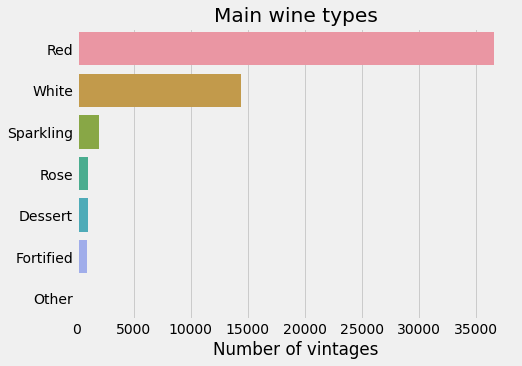

In [525]:
# plt.style.use('fivethirtyeight')
type_freq = df['type_name'].value_counts()
plt.figure(figsize=(7, 5))
sns.barplot(orient='h', x=type_freq.values, y=type_freq.index)
plt.xlabel('Number of vintages')
plt.title('Main wine types')
plt.show()

## Analysis of correlations with price

<AxesSubplot:title={'center':'Heatmap of existing variables'}>

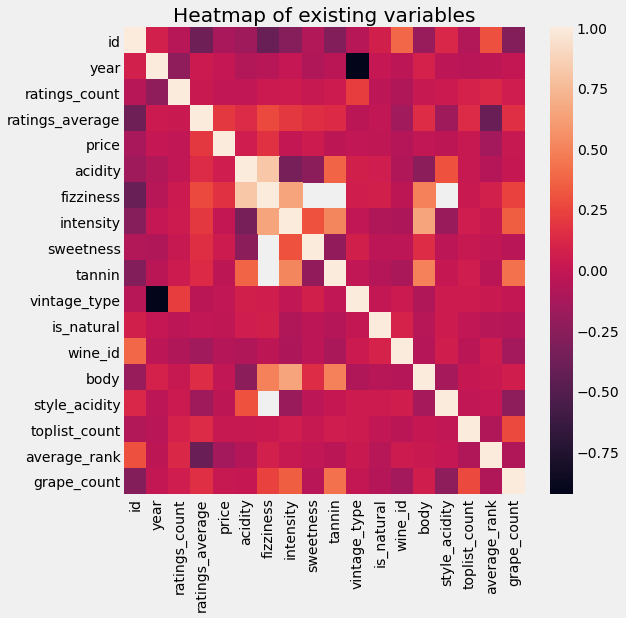

In [534]:
plt.figure(figsize=(8, 8))
plt.title('Heatmap of existing variables')
sns.heatmap(df.corr())

None of the existing numerical variables demonstrates high carrelation with the price (the only one that looks slightly promising is `average_rank`.

(1950.0, 2020.0)

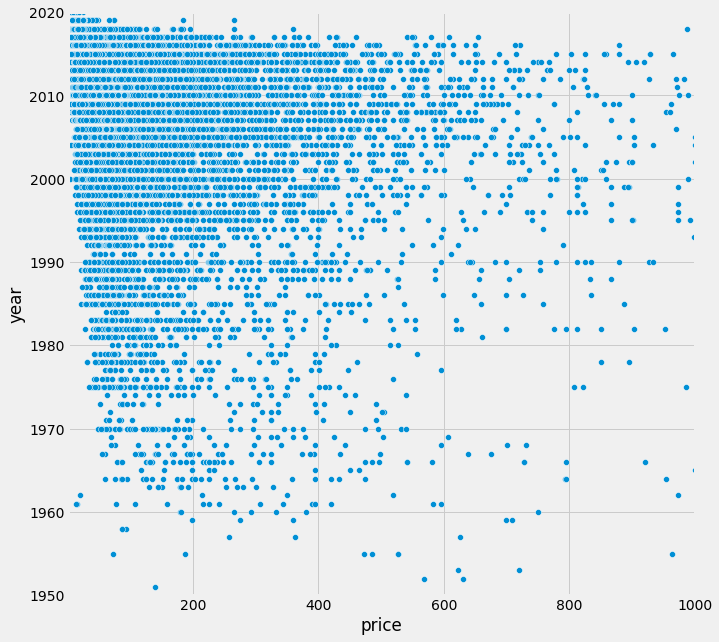

In [173]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['price'], y=df['year'])
plt.xlim((1, 1000))
plt.ylim((1950, 2020))

In [ ]:
def map_period()

(0.0, 5.0)

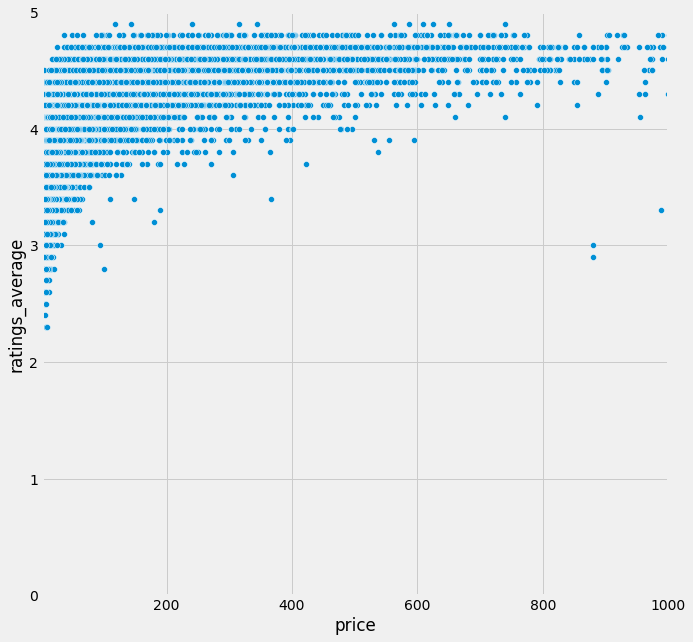

In [174]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['price'], y=df['ratings_average'])
plt.xlim((1, 1000))
plt.ylim((0, 5))

(0.0, 20000.0)

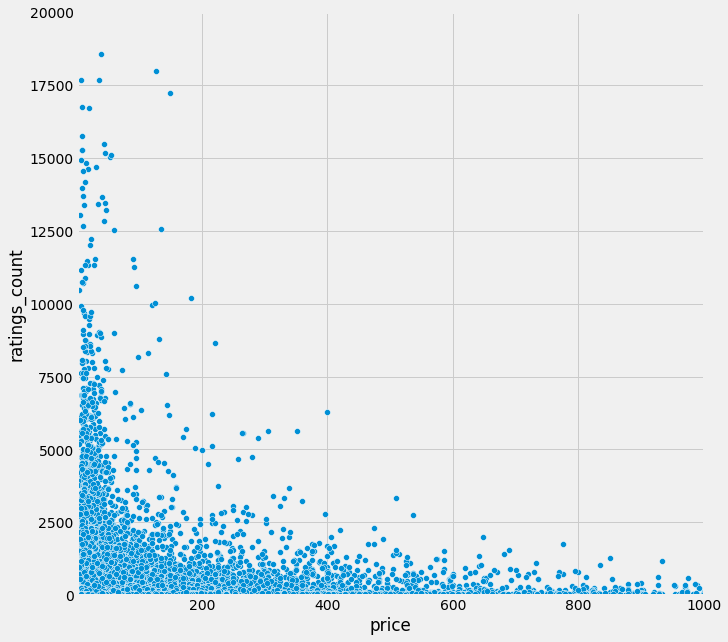

In [175]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['price'], y=df['ratings_count'])
plt.xlim((1, 1000))
plt.ylim((0, 20000))
# plt.ylim((1950, 2020))

<AxesSubplot:xlabel='price', ylabel='Count'>

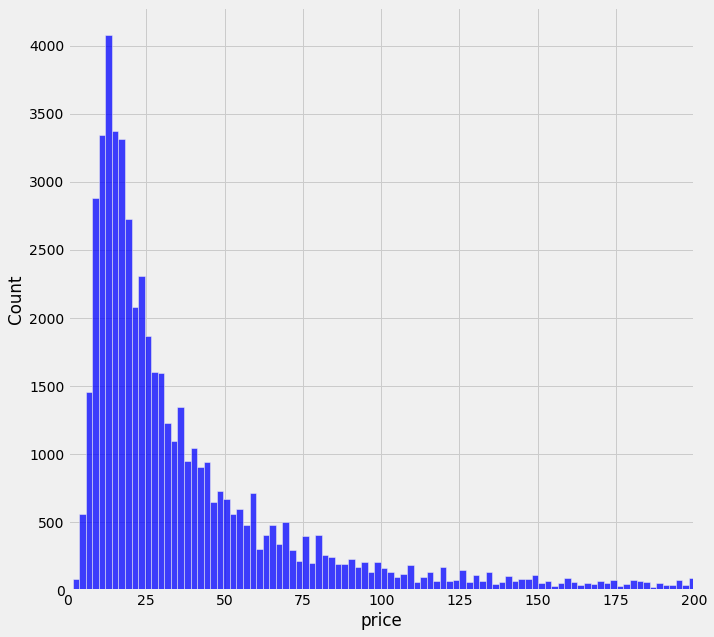

In [176]:
plt.figure(figsize=(10, 10))
plt.xlim((0, 200))
sns.histplot(df['price'])

<AxesSubplot:xlabel='ratings_average', ylabel='Density'>

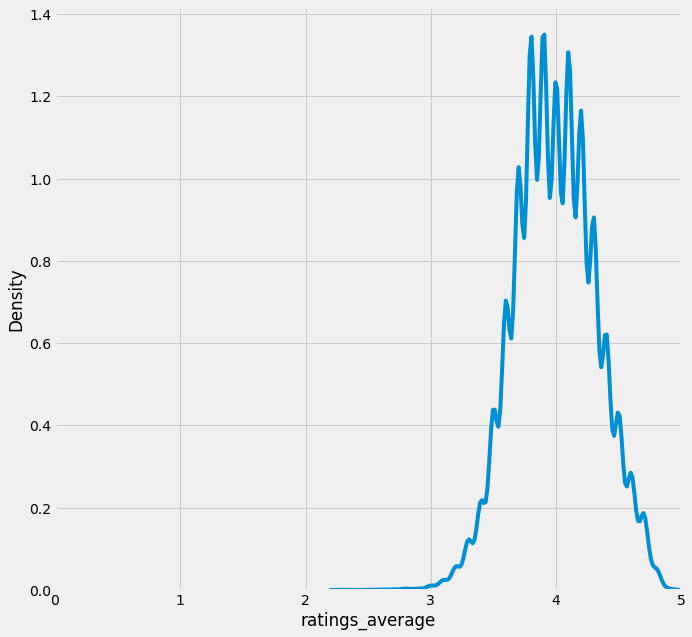

In [177]:
plt.figure(figsize=(10, 10))
plt.xlim((0, 5))
sns.kdeplot(df['ratings_average'])

<AxesSubplot:xlabel='is_natural', ylabel='price'>

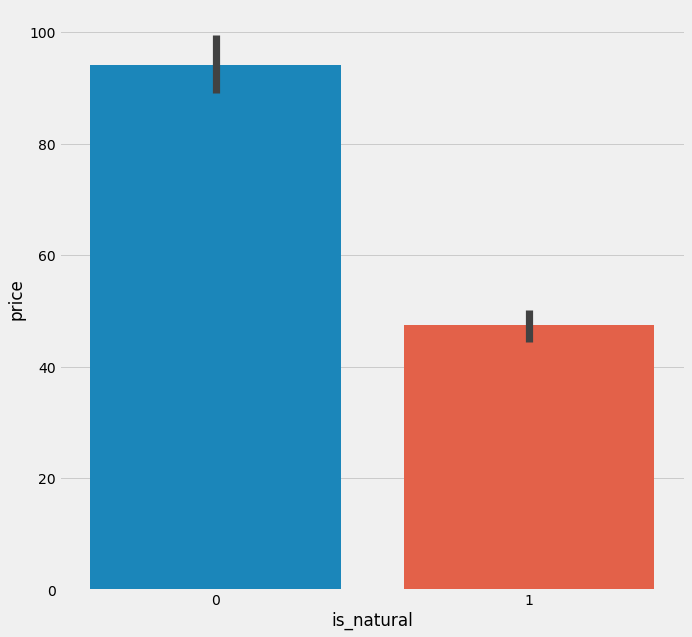

In [178]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
sns.barplot(x=df['is_natural'], y=df['price'])

In [159]:
df['is_natural'].value_counts()

0    53333
1     2486
Name: is_natural, dtype: int64

<AxesSubplot:xlabel='type_name', ylabel='price'>

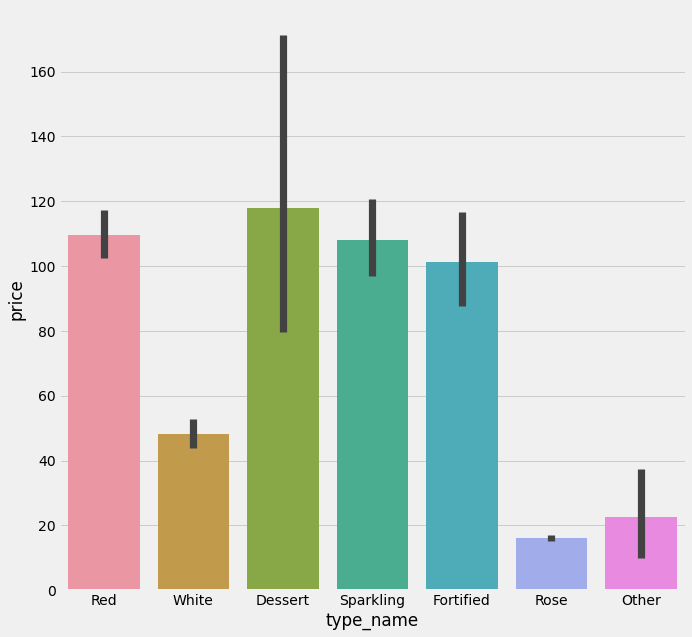

In [179]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
sns.barplot(x=df['type_name'], y=df['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

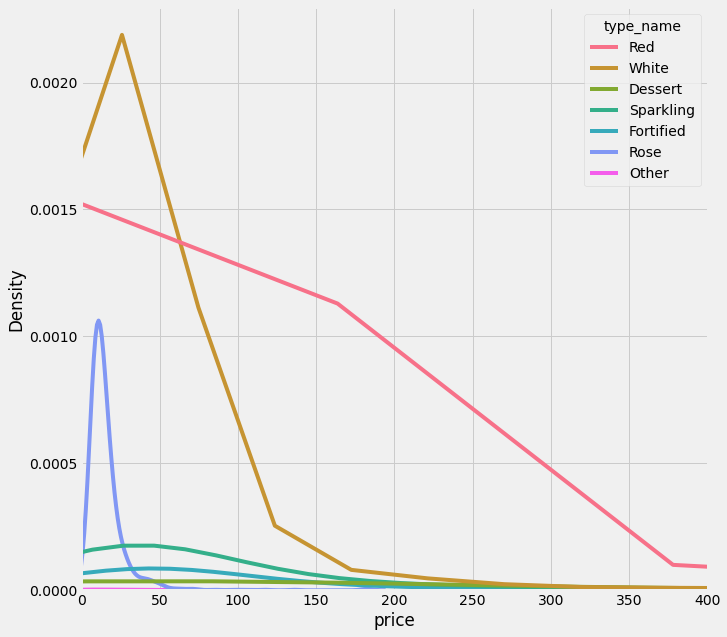

In [248]:
plt.figure(figsize=(10, 10))
plt.xlim((0, 400))
sns.kdeplot(x=df['price'], hue=df['type_name']) #, hue=['vintage_type']

<AxesSubplot:xlabel='grape_count', ylabel='price'>

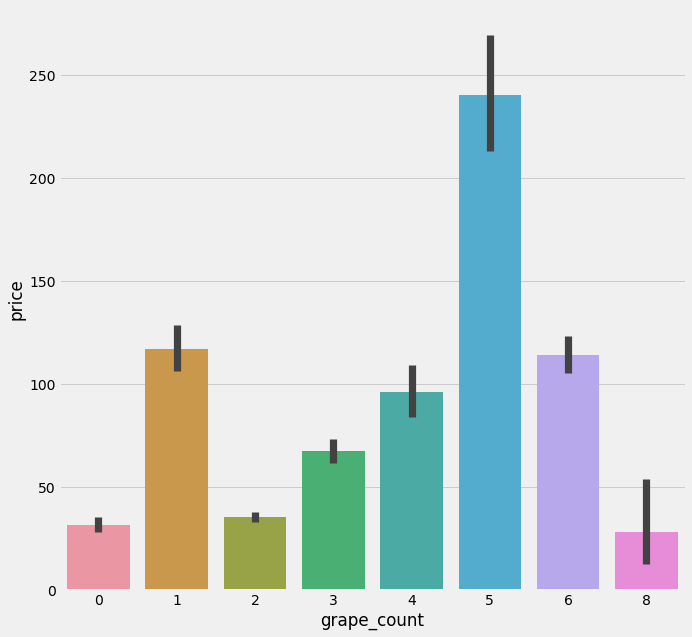

In [180]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
sns.barplot(x=df['grape_count'], y=df['price'])

<AxesSubplot:xlabel='type_name', ylabel='grape_count'>

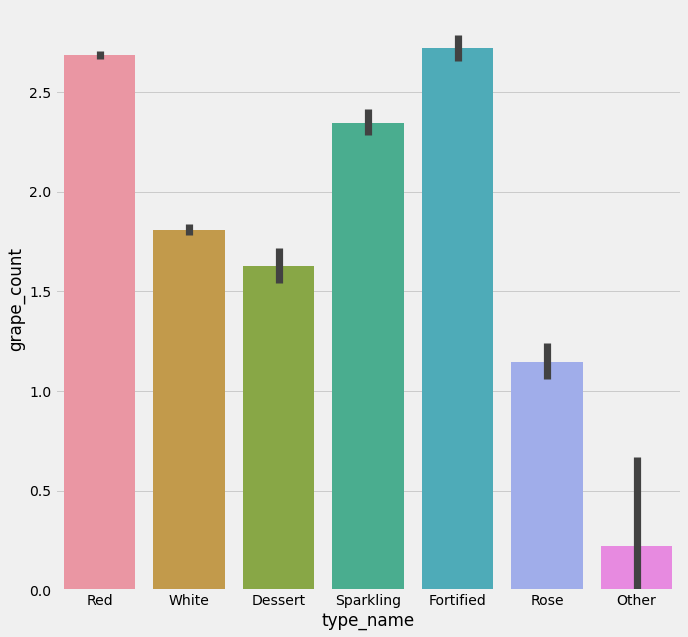

In [181]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
sns.barplot(x=df['type_name'], y=df['grape_count'])

In [323]:
query = """
SELECT v.id, v.year, v.ratings_count, v.ratings_average, v.price,
w.acidity, w.fizziness, w.intensity, w.sweetness, w.tannin, w.vintage_type, w.seo_name AS wine_name, w.id AS wine_id,
r.name AS region,
c.name AS country,
s.name AS style_name, s.body, s.acidity AS style_acidity,
t.name AS type_name,
g.name AS grapes,
w2.name AS winery_name
FROM vintage AS v
LEFT JOIN wine AS w ON w.id = v.wine_id
LEFT JOIN region AS r ON w.region_id = r.id
LEFT JOIN country AS c on r.country_code = c.code
LEFT JOIN style AS s ON w.style_id = s.id
LEFT JOIN type AS t ON t.id = w.type_id
LEFT JOIN style_grape AS sg ON sg.style_id = s.id
LEFT JOIN grape AS g ON sg.grape_id = g.id
LEFT JOIN winery AS w2 ON w2.id = w.winery_id
"""

df_grapes = pd.read_sql(query, con=db_connection)
df_grapes.head()

,id,year,ratings_count,ratings_average,price,acidity,fizziness,intensity,sweetness,tannin,...,wine_name,wine_id,region,country,style_name,body,style_acidity,type_name,grapes,winery_name
0,1832,2005,169,4.5,299.50,3.39891,NaN,3.98319,1.71259,3.52832,...,bin-707-cabernet-sauvignon,1264,South Australia,Australia,Australian Cabernet Sauvignon,4.0,3.0,Red,Cabernet Sauvignon,Penfolds
1,2036,2005,537,4.4,46.39,3.10746,NaN,3.43923,1.82238,2.92387,...,siepi,1471,Toscana,Italy,Tuscan Red,3.0,2.0,Red,Cabernet Sauvignon,Mazzei
2,2036,2005,537,4.4,46.39,3.10746,NaN,3.43923,1.82238,2.92387,...,siepi,1471,Toscana,Italy,Tuscan Red,3.0,2.0,Red,Merlot,Mazzei
3,2036,2005,537,4.4,46.39,3.10746,NaN,3.43923,1.82238,2.92387,...,siepi,1471,Toscana,Italy,Tuscan Red,3.0,2.0,Red,Sangiovese,Mazzei
4,2036,2005,537,4.4,46.39,3.10746,NaN,3.43923,1.82238,2.92387,...,siepi,1471,Toscana,Italy,Tuscan Red,3.0,2.0,Red,Canaiolo Nero,Mazzei


In [192]:
df_grapes['grapes'].describe()

count                 134084
unique                   128
top       Cabernet Sauvignon
freq                   11078
Name: grapes, dtype: object

In [324]:
df_grapes['winery_name'].describe()

count            140117
unique            10026
top       M. Chapoutier
freq                579
Name: winery_name, dtype: object

In [325]:
df_grapes = pd.merge(left=df_grapes, right=df[['id', 'grape_count']], on='id')
# df_grapes.join(df, on='id', rsuffix=).head(20)

In [326]:
df_grapes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140137 entries, 0 to 140136
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               140137 non-null  int64  
 1   year             140137 non-null  int64  
 2   ratings_count    140137 non-null  int64  
 3   ratings_average  140137 non-null  float64
 4   price            140137 non-null  float64
 5   acidity          129993 non-null  float64
 6   fizziness        4490 non-null    float64
 7   intensity        129993 non-null  float64
 8   sweetness        125503 non-null  float64
 9   tannin           97026 non-null   float64
 10  vintage_type     140137 non-null  int64  
 11  wine_name        140137 non-null  object 
 12  wine_id          140137 non-null  int64  
 13  region           140081 non-null  object 
 14  country          140081 non-null  object 
 15  style_name       134084 non-null  object 
 16  body             134084 non-null  floa

In [132]:
# df_grapes['grape_count'] = df_grapes['grapes'].apply(lambda x: len(df_grapes['grapes'] == x))

In [216]:
grapes_grouped = df_grapes.groupby(['grapes', 'grape_count'])[['price', 'ratings_average']].median()
.sort_values(by='price', ascending=False).reset_index()

In [269]:
unique_red_grape_prices = df_grapes[(df_grapes['grape_count']==1)&
          (df_grapes['type_name'] == 'Red')&
          (df_grapes['price'] < 1000)].groupby('grapes')['price'].mean().sort_values(ascending=False)
unique_red_grape_prices

grapes
Cabernet Sauvignon    101.062311
Nebbiolo               89.947765
Pinot Noir             85.946147
Sangiovese             82.516951
Tempranillo            64.403477
Shiraz/Syrah           57.663446
Montepulciano          36.373926
Cabernet Franc         32.862619
Barbera                29.288670
Mencia                 25.874386
Zinfandel              24.567376
Malbec                 24.168285
Blaufränkisch          23.847539
Gamay                  23.801733
Tannat                 22.781332
Petite Sirah           22.526154
Xinomavro              21.056111
Pinotage               20.446842
Touriga Nacional       20.104242
Merlot                 19.496001
Grenache               19.034644
Agiorgitiko            18.460000
Carménère              17.556647
Bonarda                16.951754
Primitivo              16.913760
Mourvedre              15.637198
Dornfelder             15.120000
Zweigelt               13.195512
Name: price, dtype: float64

In [311]:
red_grape_prices = df_grapes[(df_grapes['type_name'] == 'Red')&(df_grapes['price'] < 1000)]
red_grapes_high = list(red_grape_prices.groupby('grapes')['price'].mean().sort_values(ascending=False).head(15).index)
# red_grape_prices.groupby('grapes')['price'].mean().sort_values(ascending=False)

In [275]:
red_grapes_high

['Viognier',
 'Petit Verdot',
 'Cabernet Franc',
 'Cabernet Sauvignon',
 'Merlot',
 'Malbec',
 'Pinot Noir',
 'Counoise',
 'Muscardin',
 'Cinsaut',
 'Vaccareze',
 'Carménère',
 'Carignan',
 'Nebbiolo',
 'Sangiovese']

<AxesSubplot:xlabel='price', ylabel='grapes'>

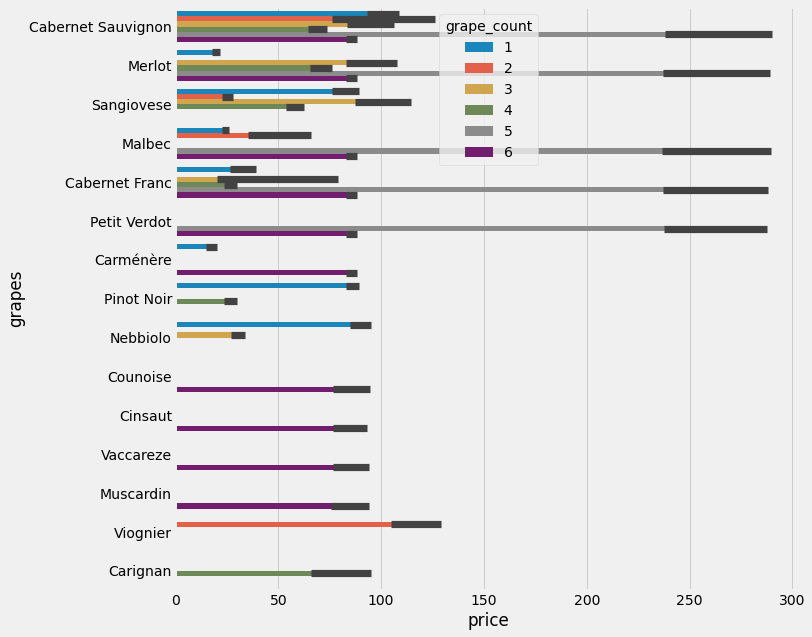

In [277]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
high_red_grape_prices = red_grape_prices[red_grape_prices['grapes'].apply(lambda x: x in red_grapes_high)]
sns.barplot(y=high_red_grape_prices['grapes'], x=high_red_grape_prices['price'], hue = high_red_grape_prices['grape_count'], orient='h')

In [287]:
high_red_grape_prices[high_red_grape_prices['grape_count'] == 5]['grapes'].value_counts()

Malbec                206
Cabernet Sauvignon    206
Petit Verdot          206
Cabernet Franc        206
Merlot                206
Name: grapes, dtype: int64

All expensive 5-grape wines correspond to the special US blend (Napa Valley Bordeaux Blend). The grapes are: 
* Malbec
* Cabernet Sauvignon
* Petit Verdot
* Cabernet Franc
* Merlot

In [295]:
df_grapes[df_grapes['grape_count'] == 5]['style_name'].value_counts()

Napa Valley Bordeaux Blend    1055
Santorini White                165
Portuguese Madeira             160
Portuguese Port                 20
Luxembourg Crémant               5
Name: style_name, dtype: int64

Less expensive blends of 5 types of grapes can be found in Santorini and Portugal.

In [286]:
high_red_grape_prices[high_red_grape_prices['grape_count'] == 6]['grapes'].value_counts()

Malbec                7194
Merlot                7194
Cabernet Sauvignon    7194
Petit Verdot          7194
Carménère             7194
Cabernet Franc        7194
Cinsaut                707
Counoise               707
Muscardin              707
Vaccareze              707
Name: grapes, dtype: int64

Different variations of 6-grape wine blend mostly relates to various French Bordeaux blend styles. The grapes are: 
* Malbec
* Merlot
* Cabernet Sauvignon
* Petit Verdot
* Carménère
* Cabernet Franc

In [299]:
df_grapes[df_grapes['grape_count'] == 6]['country'].value_counts()

France           45708
Portugal          4062
South Africa      1392
Chile              498
Australia          474
Argentina          444
United States      438
New Zealand        342
Brazil              12
Name: country, dtype: int64

In [338]:
french_bardeux_styles = df_grapes[(df_grapes['country'] == 'France') & 
          (df_grapes['grape_count'] == 6) & 
          (df_grapes['type_name'] == 'Red')&
          ((df_grapes['grapes'] == 'Malbec')|
          (df_grapes['grapes'] == 'Merlot')|
          (df_grapes['grapes'] == 'Cabernet Sauvignon')|
          (df_grapes['grapes'] == 'Petit Verdot')|
          (df_grapes['grapes'] == 'Carménère')|
          (df_grapes['grapes'] == 'Cabernet Franc'))]['style_name'].unique()

french_bardeux_styles

# .groupby('style_name')[['price', 'ratings_average', 'acidity', 'intensity', 'sweetness', 'tannin', 'body']].agg({
#     'price': ['median', 'mean', 'sem']}).sort_values(by='price', ascending=False)

array(['Bordeaux Margaux', 'Bordeaux Pauillac', 'Bordeaux Saint-Émilion',
       'Bordeaux Pessac-Léognan', 'Bordeaux Médoc', 'Bordeaux Red',
       'Bordeaux Saint-Julien', 'Bordeaux Saint-Estèphe',
       'Bordeaux Pomerol', 'Bordeaux Libournais Red',
       'Bordeaux Graves Red'], dtype=object)

In [343]:
french_bardeux_styles_df = df[df['style_name'].apply(lambda x: x in french_bardeux_styles)]

In [349]:
french_bardeux_styles_df.pivot_table(values=['price', 'ratings_average'], 
                                     index='style_name', 
                                     aggfunc=['median', 'mean', 'sem']).sort_values(by=('median','price'), ascending=False)

median                        mean                  \
                            price ratings_average       price ratings_average   
style_name                                                                      
Bordeaux Pauillac        89.97500             4.3  240.485616        4.245619   
Bordeaux Pomerol         68.16665             4.2  301.193434        4.193519   
Bordeaux Saint-Julien    66.39000             4.2   96.668965        4.148893   
Bordeaux Pessac-Léognan  55.66665             4.1  121.458970        4.143625   
Bordeaux Margaux         52.32000             4.1  114.234220        4.133869   
Bordeaux Saint-Émilion   51.85000             4.1  110.025381        4.126024   
Bordeaux Saint-Estèphe   41.42835             4.0   63.611309        4.021564   
Bordeaux Médoc           23.91000             3.8   28.839405        3.807917   
Bordeaux Libournais Red  21.50000             3.8   28.370858        3.822222   
Bordeaux Graves Red      15.95000             3.8   19.956396        3.723636   
Bordeaux Red             14.33330             3.7   76.173170        3.709980   

                               sem                  
                             price ratings_average  
style_name                                          
Bordeaux Pauillac        20.543546        0.009617  
Bordeaux Pomerol         34.431673        0.009017  
Bordeaux Saint-Julien     7.774124        0.008743  
Bordeaux Pessac-Léognan   8.853069        0.011708  
Bordeaux Margaux         14.699386        0.008666  
Bordeaux Saint-Émilion    5.963233        0.007220  
Bordeaux Saint-Estèphe    3.185621        0.010740  
Bordeaux Médoc            0.582858        0.007425  
Bordeaux Libournais Red   2.940091        0.020282  
Bordeaux Graves Red       1.571471        0.028185  
Bordeaux Red             31.555002        0.013197

In [342]:
french_bardeux_styles_gb_style[['price', 'ratings_average', 'acidity', 'intensity', 'sweetness', 'tannin', 'body']].mean().sort_values(by='price', ascending=False)

,price,ratings_average,acidity,intensity,sweetness,tannin,body
style_name,,,,,,,
Bordeaux Pomerol,301.193434,4.193519,3.387339,4.215150,1.675140,3.479143,4.0
Bordeaux Pauillac,240.485616,4.245619,4.207252,4.186285,1.604339,4.211606,4.0
Bordeaux Pessac-Léognan,121.458970,4.143625,4.238974,4.216557,1.623638,4.288859,4.0
Bordeaux Margaux,114.234220,4.133869,4.189334,3.788568,1.558502,3.844026,4.0
Bordeaux Saint-Émilion,110.025381,4.126024,3.401094,4.243660,1.628031,3.530475,4.0
Bordeaux Saint-Julien,96.668965,4.148893,4.209980,3.819004,1.617608,3.884615,4.0
Bordeaux Red,76.173170,3.709980,3.827928,3.875416,1.477113,3.574990,4.0
Bordeaux Saint-Estèphe,63.611309,4.021564,4.218859,4.273537,1.576209,4.287107,4.0
Bordeaux Médoc,28.839405,3.807917,4.201185,4.239822,1.514641,4.242542,4.0


In [328]:
df_grapes[(df_grapes['country'] == 'France') & 
          (df_grapes['grape_count'] == 6) & 
          (df_grapes['type_name'] == 'Red')&
          ((df_grapes['grapes'] == 'Malbec')|
          (df_grapes['grapes'] == 'Merlot')|
          (df_grapes['grapes'] == 'Cabernet Sauvignon')|
          (df_grapes['grapes'] == 'Petit Verdot')|
          (df_grapes['grapes'] == 'Carménère')|
          (df_grapes['grapes'] == 'Cabernet Franc'))].groupby('winery_name')[['price', 'ratings_average', 'acidity', 
                                                                             'intensity', 'sweetness', 'tannin', 'body']].median().sort_values(
    by='price', ascending=False).head(30)

,price,ratings_average,acidity,intensity,sweetness,tannin,body
winery_name,,,,,,,
Domaine du Cheval Blanc,14061.70000,4.40,3.87899,3.574900,1.63391,3.69600,4.0
Liber Pater,3870.00000,4.50,3.72679,3.764940,2.01607,3.61845,4.0
Le Pin,2550.00000,4.70,3.39392,4.181650,1.94938,3.27594,4.0
Château Petrus Gaïa,2154.18000,3.70,3.64573,3.824070,2.06523,3.48121,4.0
Pétrus,2071.67000,4.70,3.39047,4.150430,1.97755,3.47865,4.0
Château Lafite Rothschild,460.00000,4.50,4.15998,4.019980,1.64574,4.16660,4.0
Château Lafleur,451.04000,4.40,3.35799,4.109070,1.82376,3.58305,4.0
Château Cheval Blanc,370.00000,4.60,3.38568,4.018480,1.71966,3.47160,4.0
Château Latour,368.05000,4.50,4.17666,4.145310,1.65428,4.19408,4.0


In [312]:
df_grapes[(df_grapes['country'] == 'France') & 
          (df_grapes['grape_count'] == 6) & 
          (df_grapes['type_name'] == 'Red')&
          ((df_grapes['grapes'] == 'Malbec')|
          (df_grapes['grapes'] == 'Merlot')|
          (df_grapes['grapes'] == 'Cabernet Sauvignon')|
          (df_grapes['grapes'] == 'Petit Verdot')|
          (df_grapes['grapes'] == 'Carménère')|
          (df_grapes['grapes'] == 'Cabernet Franc'))].groupby('style_name')['ratings_average'].median().sort_values(ascending=False)

style_name
Bordeaux Pauillac          4.3
Bordeaux Saint-Julien      4.2
Bordeaux Pomerol           4.2
Bordeaux Saint-Émilion     4.1
Bordeaux Pessac-Léognan    4.1
Bordeaux Margaux           4.1
Bordeaux Saint-Estèphe     4.0
Bordeaux Médoc             3.8
Bordeaux Libournais Red    3.8
Bordeaux Graves Red        3.8
Bordeaux Red               3.7
Name: ratings_average, dtype: float64

As can be seen from the full range of 6-grape wine blends, the French ones have absolute majority

In [293]:
high_red_grape_prices[high_red_grape_prices['grape_count'] == 1]['grapes'].value_counts()

Pinot Noir            4758
Nebbiolo              1632
Cabernet Sauvignon    1315
Malbec                 648
Sangiovese             544
Merlot                 318
Carménère              130
Cabernet Franc          42
Name: grapes, dtype: int64

In [262]:
df_grapes[(df_grapes['grape_count']==1)&(df_grapes['type_name'] == 'White')&(df_grapes['price'] < 1000)].groupby('grapes')['price'].mean().sort_values(ascending=False)

grapes
Savagnin                  74.162222
Chardonnay                42.536688
Riesling                  32.263825
Viognier                  32.194068
Chasselas                 30.777500
Shiraz/Syrah              30.000000
Chenin Blanc              27.605377
Viura                     25.759060
Gewürztraminer            24.269578
Pinot Gris                23.938970
Koshu                     22.451000
Grüner Veltliner          21.979692
Silvaner                  21.714512
Trebbiano                 21.486299
Pedro Ximenez             20.990000
Albariño                  17.978032
Cortese                   16.674929
Pinot Blanc               16.654783
Sauvignon Blanc           15.342414
Malagouzia                14.580000
Verdejo                   14.349215
Müller-Thurgau            14.330000
Pinot Grigio              13.736512
Melon de Bourgogne        13.468683
Torrontés                 13.033882
Moscatel de Alejandría     9.112500
Name: price, dtype: float64

In [227]:
grapes_grouped_no_count = df_grapes.groupby('grapes')['price'].median().sort_values(ascending=False)
grapes_high = list(grapes_grouped_no_count.head(30).index)
grapes_low = list(grapes_grouped_no_count.tail(30).index)
grapes_high

['Malmsey',
 'Sercial',
 'Verdelho',
 'Terrantez',
 'Boal Branco',
 'Savagnin',
 'Pinot Meunier',
 'Pinot Gris',
 'Touriga Franca',
 'Aligoté',
 'Pinot Noir',
 'Petit Verdot',
 'Muscardin',
 'Cinsaut',
 'Vaccareze',
 'Counoise',
 'Cabernet Franc',
 'Carménère',
 'Pinot Blanc',
 'Merlot',
 'Cabernet Sauvignon',
 'Viognier',
 'Malbec',
 'Nebbiolo',
 'Carignan',
 'Chardonnay',
 'Muscadelle',
 'Sémillon',
 'Sangiovese',
 'Tinta Roriz']

In [250]:
grapes_grouped_high = grapes_grouped[grapes_grouped['grapes'].apply(lambda x: x in grapes_high)]
grapes_grouped_high.head(30)

,grapes,grape_count,price,ratings_average
0,Merlot,5,219.95000,4.60
1,Malbec,5,219.95000,4.60
2,Petit Verdot,5,219.95000,4.60
3,Cabernet Sauvignon,5,219.95000,4.60
4,Cabernet Franc,5,219.95000,4.60
5,Verdelho,5,92.50000,4.35
6,Sercial,5,92.50000,4.35
7,Malmsey,5,92.50000,4.35
8,Boal Branco,5,92.50000,4.35
9,Terrantez,5,92.50000,4.35


<AxesSubplot:xlabel='price', ylabel='grapes'>

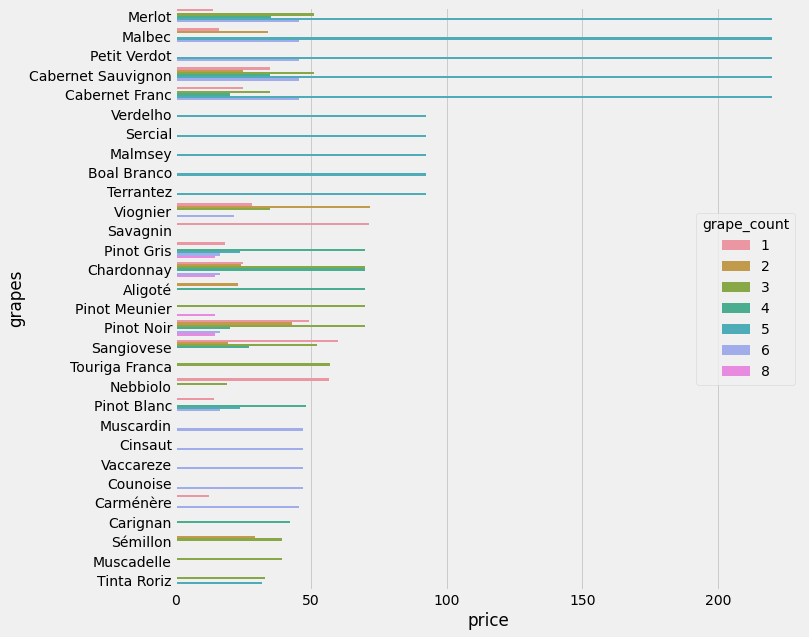

In [236]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
sns.barplot(y=grapes_grouped_high['grapes'], x=grapes_grouped_high['price'], hue = grapes_grouped_high['grape_count'], orient='h')

<AxesSubplot:xlabel='grape_count', ylabel='price'>

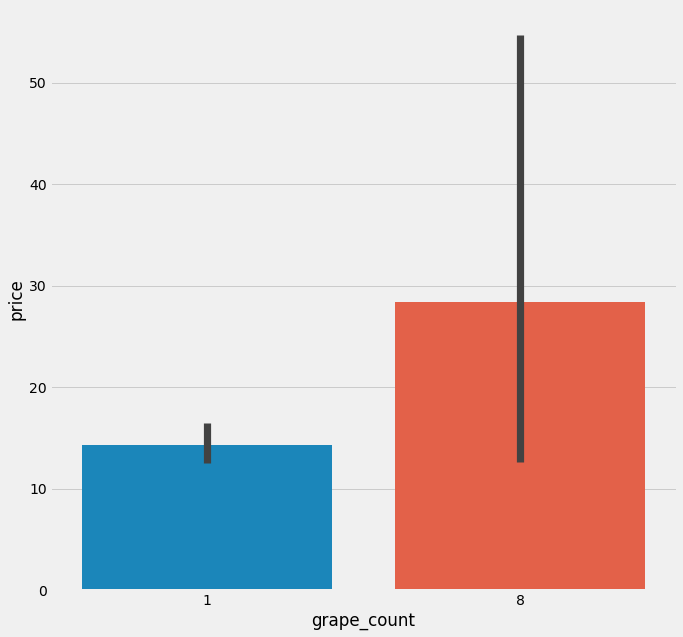

In [214]:
plt.figure(figsize=(10, 10))
# plt.xlim((0, 200))
sns.barplot(x=df_grapes[df_grapes['grapes'] == 'Verdejo']['grape_count'], y=df_grapes[df_grapes['grapes'] == 'Verdejo']['price'])